## Introduction

In this segment, we will be using the processed data from the data preparation exercise to fit and validate our Probability of Default (PD) model, capitalising on the coarse_classed variables we established in the processing exercise. There are three sections to this notebook:
- Introduction
- PD Model Development: logistic regression
- Model Validation
- Transforming the Model into a Scorecard

<br>

## PD Model Development

In this section, we will be fitting a logistic regression model to predict the PD as well as the class of the borrower. We will also handle different issues that can cause errors in our modeling exercise.

In [37]:
#Loading the needed librraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

We import our training and test datasets from the data processing exercise.

In [38]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

We print the dimensions of our training and testing data to ensure everything is in order

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(373028, 81)
(373028, 1)
(93257, 81)
(93257, 1)


<br>
To get a list of the reference categories for our dummy variables, we take the first dummy belonging to each of the predictor variables.

In [40]:
seen_categories = []
ref_categories = []

for col in X_test.columns.values[1:]:
    variable = col.split(':')[0]
    if variable not in seen_categories:
        seen_categories.append(variable)
        ref_categories.append(col)

ref_categories

['Grade:_A',
 'home_ownership:_MORTGAGE',
 'addr_state:_AL',
 'verif:_Not Verified',
 'purpose:_cred-card',
 'init_list_status:_f',
 'term:_36',
 'empLength: _(-inf, 0.0]',
 'mths_sinc_issue:_(-inf, 0.0]',
 'int_rate: _(5, 10]',
 'annual_inc: _0k-20k',
 'DtI: _(8, 12]',
 'mths_last_record: _(0.0, 70.0]']

We add an intercept column of 1s to our training and testing data.

In [41]:
#Add constant for intercept
X_train_with_const = X_train.drop(ref_categories + ['id'], axis = 1)
X_train_with_const.insert(0, 'intercept', 1)
X_train_with_const['intercept'] = X_train_with_const.intercept.astype(bool)


## Add constant and drop the reference categories from the testing data
X_test_with_const = X_test.drop(ref_categories + ['id'], axis = 1)
X_test_with_const.insert(0, 'intercept', 1)
X_test_with_const['intercept'] = X_test_with_const.intercept.astype(bool)


- We can fit the logistic regression model using the statsmodels module using two functions:
    - sm.GLM()
    - sm.Logit()

The first method will not require any further processing from our side. The second however will yield an error if we have dummy columns that have no values (i.e. constant variance). The approach for the first method is commented out below.

In [42]:

# To ensure that we don't have a singular X_train matrix, we need to check if determinant of the correlation matrix exists and is not 0.
# Below we get nan, indicating that we have columns with no variance
corr_matrix = X_train_with_const.corr()
det_corr = np.linalg.det(corr_matrix)
print(f"Determinant of Correlation Matrix: {det_corr}")

Determinant of Correlation Matrix: nan


/home/mohammad/Desktop/Practice/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2432: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


<br>
To use the sm.logit() function, we check columns that have zero variance (i.e. one unique value throughout). We see that aside from the intercept, we have two columns that needs to be removed as they contain no data.

In [43]:
# Get column names where the number of unique values is 1
zero_var_cols = X_train_with_const.columns[X_train_with_const.nunique() == 1]
zero_var_cols = zero_var_cols.tolist() # convert columns' names to a list
zero_var_cols = [col for col in zero_var_cols if col != 'intercept']
print("Constant columns:", zero_var_cols)

# Remove constant columns Except the intercept
X_train_with_const  = X_train_with_const.drop(zero_var_cols, axis = 1)
X_test_with_const  = X_test_with_const.drop(zero_var_cols, axis = 1)

# Use the following to ensure X_train_with_const is a Proper NumPy Array
# WARNING: SHOULD DO THE SAME FOR TESTING DATA- SEE Cell 439
#X_train_with_const = X_train_with_const.astype(float)

Constant columns: ['empLength: _(10.0, inf]', 'mths_last_record: _(130.0, inf]']


<br>
Finally, we can fit our logistic regression model with the remaining predictors.

In [44]:
import statsmodels.api as sm

# Fitting the model
model = sm.Logit(y_train, X_train_with_const).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.321633
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               good_bad   No. Observations:               373028
Model:                          Logit   Df Residuals:                   372963
Method:                           MLE   Df Model:                           64
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                 0.06782
Time:                        19:10:42   Log-Likelihood:            -1.1998e+05
converged:                       True   LL-Null:                   -1.2871e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
intercept                                                     -2.8763        nan        nan        nan         nan         nan
Grade:_B                                                       0.5423      0.037     14.599      0.000       0.469       0.615
Grade:_C                                                       0.8967      0.040     22.330      0.000       0.818       0.975
Grade:_D                                                       1.1592      0.043     26.852      0.000       1.075       1.244
Grade:_E                                                       1.4264      0.046     30.860      0.000       1.336       1.517
Grade:_F                                                       1.6831      0.050     33.618      0.000       1.585       1.781
Grade:_G                                                       2.0808      0.053     39.124      0.000       1.977       2.185
home_ownership:_OWN                                            0.0325      0.020      1.619      0.105      -0.007       0.072
home_ownership:_Othr_Own_Any                                   0.1725      0.227      0.760      0.447      -0.272       0.617
home_ownership:_RENT                                           0.1180      0.013      9.370      0.000       0.093       0.143
addr_state:_CA                                                -0.0554      0.048     -1.159      0.247      -0.149       0.038
addr_state:_FL                                                 0.0395      0.050      0.797      0.426      -0.058       0.137
addr_state:_IL_AK_VT_SC_CO_KS_MS_WV_NH_WY_DC                  -0.2959      0.049     -6.038      0.000      -0.392      -0.200
addr_state:_MA_WA_WI_IN_GA                                    -0.1275      0.049     -2.623      0.009      -0.223      -0.032
addr_state:_MD                                                 0.0149      0.057      0.261      0.794      -0.097       0.126
addr_state:_MO_TN_RI_AR_UT_PA_SD_OK_OH_KY_MN                  -0.0939      0.048     -1.977      0.048      -0.187      -0.001
addr_state:_NC                                                -0.0129      0.055     -0.233      0.816      -0.121       0.095
addr_state:_NE_ID_ME_IA_NV_HI                                  0.1040      0.058      1.802      0.072      -0.009       0.217
addr_state:_NM_NJ_LA_DE_VA_MI_AZ                              -0.0261      0.048     -0.546      0.585      -0.120       0.067
addr_state:_NY                                                -0.0169      0.049     -0.344      0.731      -0.113       0.079
addr_state:_OR_CT_MT                                          -0.2008      0.056     -3.612      0.000      -0.310      -0.092
addr_state:_TX                                                -0.2204      0.050     -4.412      0.000      -0.318      -0.122
verif:_Source Verified                                         0.0

#### Saving the model

In [73]:
import pickle

with open('PD_model.pkl', 'wb') as f:
    pickle.dump(model, f)

<br>

## Model Validation

### Out-of-sample validation

<br>

To assess the predictive performance of our model, we use our model to predict the class for the testing data. Then we establish a confusion matrix at a standard cut-off rate of 0.5. Ideally, we would look for a cut-off that maximizes Sensitivity Rate + Specificity Rate (or True Positive Rate + True Neative Rate). However, our focus in this exercise is to maximize default detection. Hence, we will see few cells down how to change the cut-off to maximize Sensitivity Rate.

In [45]:
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(X_test_with_const)
y_pred_class = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary labels

#Generating a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

[[83044    14]
 [10191     8]]


We can also print out the Accuracy and Sensitivity (True Positive) Rate of our model.

In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")

## Alternative for calculating score
# accuracy = (predicted_classes == y_test).mean()
# print(f"Accuracy: {accuracy:.4f}")

# Calculating "Sensitivity" or true positive rate
Sensitivity = conf_matrix[1,1] / sum(conf_matrix[1:]).sum()
print(f'Sensitivity: {Sensitivity:.4f}')


Accuracy: 0.8906
Sensitivity: 0.0008


It can be noted that our model generally has very high accuracy overall. However, our critical performance indicator is the ***true positives rate which is very weak in our model***. This is due to our choice of a moderate cut-off threshold of 0.5. We need to chosse a more conservative cut-off threshold.

If we choose a cut-off of 0.1, Sensitivity or True Positive Rate is at 68.6% which is much better at predicting default.

In [47]:
# Changing our cut-off threshold
y_pred_class = (y_pred_prob >= 0.1).astype(int)  # Convert probabilities to binary labels

#Generating a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

# Calculating "Sensitivity" or true positive rate
Sensitivity = conf_matrix[1,1] / sum(conf_matrix[1:]).sum()
print(f'Sensitivity: {Sensitivity:.4f}')

[[47332 35726]
 [ 2867  7332]]
Sensitivity: 0.7189


<br>

#### Receiver Operating Characteristic (ROC) Curve

One of the main methods to evaluate the strength of our model is to plot the Receiver Operating Characteristic (ROC) Curve which plots the True Positive Rates (tpr) against False Positive Rates (tpr) for different cut-off thresholds. In other words, every point across the ROC curve corresponds to a specific confusion matrix.

Of particular importance is the area under the ROC curve, called Area under the Cuver (AUC). This area is compared to a threshold of 50% (classifying outcomes based on chance). If the AUC is very close to 50%, the model is not effective at all. If the area is close to 100%, the model has high predictive performance. The following table shows **the interpretation for different AUC values**:


| **AUC Score** | **Model Performance** |
|--------------|----------------------|
| **0.5**      | Random classifier (no discrimination) |
| **0.6 - 0.7** | Poor model |
| **0.7 - 0.8** | Fair model |
| **0.8 - 0.9** | Good model |
| **0.9 - 1.0** | Excellent model |


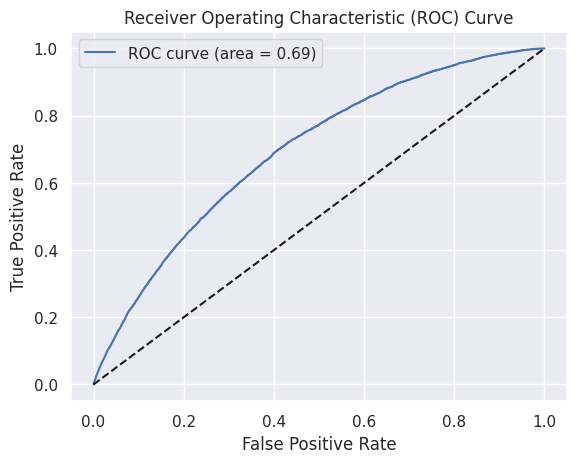

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

We can see that the AUC is close to 0.69 which is an indication of not a very strong model.

In [49]:
#Another method to calculate AUC
from sklearn.metrics import roc_auc_score

AUC = roc_auc_score(y_test, y_pred_prob)
print(f"AUC is : {AUC:.4f}")

AUC is : 0.6950


<br>

#### **Gini and Kolmogorov Smirnov Indicators**

In [50]:
df_compare = pd.DataFrame({'y_pred_class': y_pred_class, 'y_pred_prob' : y_pred_prob, 'actual': y_test.good_bad})

To calculate Gini and KS indicators, we must establish the cumulative percentage of our model

In [51]:
df_compare = df_compare.sort_values('y_pred_prob').reset_index()

Now we calculate the cumulative percentages for:
- Total population
- good borrowers from total of good
- bad borrower from total of bad

In [52]:
df_compare['Cum_n_population'] = df_compare.index + 1
df_compare['Cum_n_bad'] = df_compare.actual.cumsum()
df_compare['Cum_n_good'] = df_compare.Cum_n_population - df_compare.Cum_n_bad

In [53]:
df_compare['Cum_perc_population'] = df_compare.Cum_n_population/ df_compare.shape[0]
df_compare['Cum_perc_bad'] = df_compare.Cum_n_bad / df_compare.actual.value_counts().loc[1]
df_compare['Cum_perc_good'] = df_compare.Cum_n_good / df_compare.actual.value_counts().loc[0]

Text(0.5, 1.0, 'Gini')

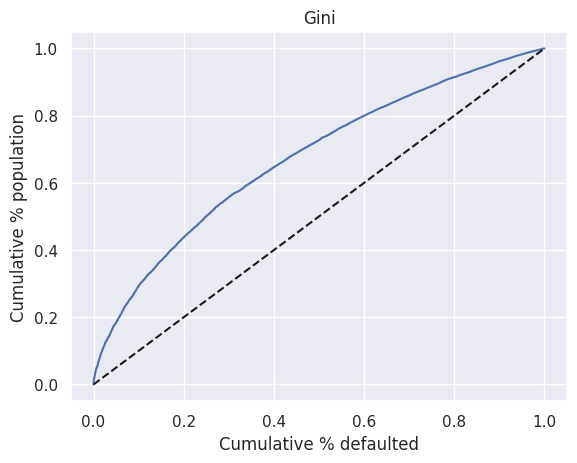

In [54]:
plt.plot(df_compare.Cum_perc_bad, df_compare.Cum_perc_population)
plt.plot([df_compare.Cum_perc_bad.min(), df_compare.Cum_perc_bad.max()],
           [df_compare.Cum_perc_bad.min(), df_compare.Cum_perc_bad.max()],
           color = 'k', linestyle = '--')
plt.xlabel('Cumulative % defaulted')
plt.ylabel('Cumulative % population')
plt.title('Gini')

As could be probably be guessed from the plot, the Gini curve is a different representation of the ROC curve. In fact, we can calculate the Gini algebraically using the AUC score through the equation:

$Gini= (AUC * 2) - 1$


In [55]:
Gini= (AUC * 2) - 1
print(f"{Gini:.4f}")

0.3899


<br>

The Kolmogorove_Smirnov statistic (KS test) is the maximum distance between two Cumulative Distribution Functions (CDFs). The more apart the two CDFs are, the more evidence we have that the underlying feature is different between the two compared groups. This test is used to assess whether a variable can be assumed to have a normal distribution by comparing its empirical CDF to that of a Normal Distribution.

On one extreme, if KS statistic = 1, there is a perfect separation between the two distributions and we reject H0 (i.e. the good and bad distributions are perfectly separated by our model).
On the other extreme, if KS statistic = 0, there is no distance at all between the two distributions and we fail to reject H0.

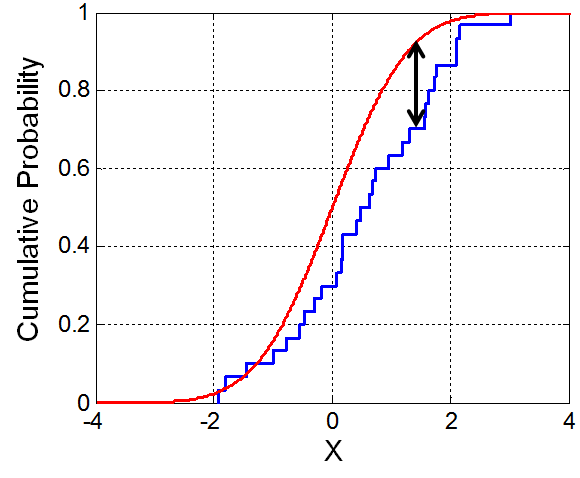



We can see from the plot below that the maximum distance between the CDFs for good and bad borrowers is somewhat satisfactory when using this model. The KS_statistic is around 0.262 which is satisfactory but not very high.

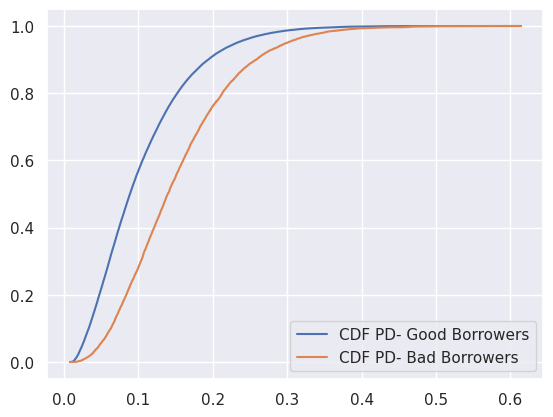

In [56]:
plt.plot(df_compare.y_pred_prob, df_compare.Cum_perc_good, label = 'CDF PD- Good Borrowers')
plt.plot(df_compare.y_pred_prob, df_compare.Cum_perc_bad, label = 'CDF PD- Bad Borrowers')
plt.legend()

In [57]:
KS = max(df_compare.Cum_perc_good - df_compare.Cum_perc_bad)
print(f"The KS statistic is: {KS:.4f}")

The KS statistic is: 0.2896


The KS test can be applied directly using the **ks_2samp()** function from the scipy.stats module.

In [58]:
from scipy.stats import ks_2samp

pos_probs = df_compare[df_compare['actual'] == 1]['y_pred_prob']
neg_probs = df_compare[df_compare['actual'] == 0]['y_pred_prob']

ks_statistic, _ = ks_2samp(pos_probs, neg_probs)

print(f"Kolmogorov-Smirnov (KS) Statistic: {ks_statistic:.4f}")

Kolmogorov-Smirnov (KS) Statistic: 0.2896


<br>

## Transforming the model into a Scorecard

Following the development and validation of our model, we need to transform it into user friendly format that can be applied by everyday users. The final format should be something like the following (which could be in Excel format):

| **Variable** | **Bucket** | **Yes/ No** |
|--------------|------------|-------------|
| **Grade**   | **A**   | - |
| **Grade**   | **B**   | Yes |
| **Grade**   | **C** | - |
| --- | **....** | - |
|**Home_ownership**| **Othr_Own_Any** | Yes |
|**Home_ownership**| **RENT** | - |
|**------**| **-----** | - |
|**------**| **-----** | - |
|**------**| **-----** | - |
| **Final Score** | **400** |

The following steps need to be take produce a scorecard such as the above:
- Define the minimum and maximum score. These should be whole integers (like 0-10) which have some meaning to everyday users rather than numbers with fractions resulting from the model and its coefficients.
- Rescale the coefficients such that the maximum and minimum potential score corresponds to the new maximum and minimum limits defined in the first step.

We start of by establishing a dataframe of our model's bins and their corresponding coefficients.

In [59]:

df_scorecard = pd.DataFrame({'Bin': X_train.columns.values[1:]})
df_scorecard.loc[-1] = 'intercept'  # Add at index -1
df_scorecard = df_scorecard.sort_index().reset_index(drop=True)  # Reorder and reset index

# Adding coefficients to the dataframe
coefficients = model.params  # This is a Series with feature names as index
# Map coefficients to the 'Bin' column, filling missing values with 0
df_scorecard['Coefficient'] = df_scorecard['Bin'].map(coefficients).fillna(0)

We now add the original feature name to the dataframe as we will need this for getting the min and max coefficient per feature.

In [61]:
# Add the original feature name- Split each bin name by : and take the first part
df_scorecard['Feature'] = df_scorecard.Bin.str.split(':').str[0]

To adjust our model score 

In [62]:
# Define the minimum and maximum score labels (business decision)
min_score = 300
max_score = 850

# Determine the minimum and maximum log-odds we will get from our PD model
min_model_score = df_scorecard.groupby('Feature')['Coefficient'].min().sum()
max_model_score = df_scorecard.groupby('Feature')['Coefficient'].max().sum()


print(f"Model default minimum score is: {min_model_score}")
print(f"Model default minimum score is: {max_model_score}")
# Note: This code gets the minimum coefficient for each feature
# df_scorecard.groupby('Feature')['Coefficient'].min()

Model default minimum score is: -5.072844498916395
Model default minimum score is: 1.2031381972259492


Now we need to rescale our coefficients such that they produce outcomes on a scale corresponding to our min/max desired scores above. To do that, we use the following equation:

$$Coef\_adjusted\_score = variable\_coef \frac {(max\_score - min\_score)} {(max\_model\_score - min\_model\_score)}$$

In [63]:
df_scorecard['Adjusted_Coef'] = df_scorecard.Coefficient*(max_score - min_score) / (max_model_score - min_model_score)

Let us check our new minimum score:

In [64]:
df_scorecard.groupby('Feature')['Adjusted_Coef'].min().sum()

np.float64(-444.5621681077905)

The reason the minimum score is still very low is because we still need to adjust the intercept. We do that with the equation:
$$Intercept\_score =  \frac {(Intercept\_coef - min\_model\_score)} {(max\_model\_score - min\_model\_score)} (max\_score - min\_score) + min\_score$$

In [65]:
df_scorecard.iloc[0, df_scorecard.columns.get_loc('Adjusted_Coef')] = ( (df_scorecard.Coefficient[0] - min_model_score) / (max_model_score - min_model_score) ) * (max_score - min_score) + min_score

We now see that the maximum and the minimum potential score correspond exactly to our specified scores.

In [66]:
adj_min = df_scorecard.groupby('Feature')['Adjusted_Coef'].min().sum()
print(f"The new adjusted min is: {adj_min}")

adj_max = df_scorecard.groupby('Feature')['Adjusted_Coef'].max().sum()
print(f"The new adjusted min is: {adj_max}")

The new adjusted min is: 300.0
The new adjusted min is: 850.0


<br>

#### Predicting PD for a new client

To get the adjusted score for all of the clients in the testing data set, we need to do the operation:
$$final\_score = X\_test . \beta$$
Where:
- X_test is a $N_{test} \times p$ matrix.
- $\beta$ is a $p \times 1$ vector.
- final_score is a $N_{test} \times 1$ vector containing the scores.

We re-establish our testing data **X_test** with an intercept (we have deleted reference categories earlier but we need them here).

In [67]:
X_test_full_with_const = X_test.drop(['id'], axis = 1)
X_test_full_with_const.insert(0, 'intercept', 1)
X_test_full_with_const['intercept'] = X_test_with_const.intercept.astype(bool)

X_test_full_with_const.shape

(93257, 81)

Our $\beta$ is the adjusted coefficients column we built in our scorecard.

In [68]:
beta = pd.DataFrame({'beta': df_scorecard.Adjusted_Coef, 'Bin' : df_scorecard.Bin})
beta.set_index('Bin', inplace = True)
beta.shape

(81, 1)

We calculate the final score as per our equation above:

In [69]:
final_score = X_test_full_with_const.dot(beta)

The final score is a transformed log-odds. We need to transform it back to log-odds with model scale and then transform back to a probability to get PD.

In [70]:
log_odds = ((final_score - min_score) / (max_score - min_score)) * (max_model_score - min_model_score) + min_model_score
log_odds = np.array(log_odds, dtype=np.float64)
PD = 1 / (1 + np.exp(-log_odds))

We finally make a comparison between the model predictions and the scorecard predictions to ensure they are identical.

In [71]:

pd.DataFrame({'model_pred' : y_pred_prob , 'Score_card' : PD.squeeze()})


,model_pred,Score_card
0,0.050454,0.050454
1,0.040483,0.040483
2,0.157679,0.157679
3,0.129487,0.129487
4,0.035110,0.035110
...,...,...
93252,0.187596,0.187596
93253,0.173988,0.173988
93254,0.269137,0.269137
93255,0.085804,0.085804
